In [39]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
import os
import cv2
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import re

In [49]:
class FaceBinaryDataset(Dataset):
    def __init__(self, root_dir, dimension = 160 ,transform=None, to_gray=False):
        self.samples = []
        self.labels = []
        self.userid = []
        self.transform = transform
        self.to_gray = to_gray
        self.dimension = dimension

        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )

        # root_dir = "dataset/"
        for label_str, label in [('authorized', 1), ('unauthorized', 0)]:
            dir_path = os.path.join(root_dir, label_str)
            for user_folder in os.listdir(dir_path):
                user_path = os.path.join(dir_path, user_folder)
                self.userid.append(re.search(r'\d+', user_folder).group())
                for img_name in os.listdir(user_path):
                    img_path = os.path.join(user_path, img_name)
                    self.samples.append(img_path)
                    self.labels.append(label)
                    

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        label = self.labels[idx]
        userid = self.userid[idx]

        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        if len(faces) == 0:
            raise ValueError(f"No face detected in: {img_path}")

        x, y, w, h = faces[0]
        face = img[y:y+h, x:x+w]
        face = cv2.resize(face, (self.dimension, self.dimension))

        if self.to_gray:
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            #face = np.expand_dims(face, axis=-1)
            
            
        face = Image.fromarray(face)


        if self.transform:
            face = self.transform(face)

            

        return face, label, userid



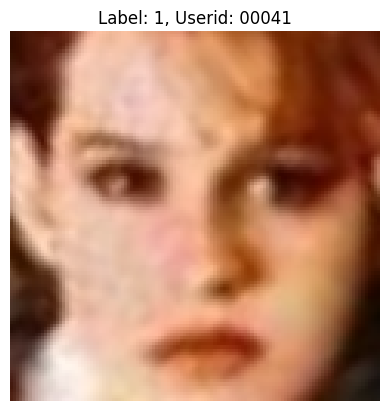

In [52]:

gray = False  #Zmiana na odcienie szarosci

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]) if gray else T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

dataset = FaceBinaryDataset("dataset/output_dataset",dimension= 120, transform=transform, to_gray=gray)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)



img, label, userid = dataset[0]


img = img.permute(1, 2, 0).numpy()

if gray:  # obraz czarno-biały
    img = img * 0.5 + 0.5
    plt.imshow(img.squeeze(), cmap='gray')
else:  # obraz kolorowy
    img = img * 0.5 + 0.5
    plt.imshow(img)


plt.title(f"Label: {label}, Userid: {userid}")
plt.axis('off')
plt.show()